# Structure similarity network construction and visualisation

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Construct structure similarity network based on Foldseek search results

### Procedure
- filter out nodes with pLDDT score of structure rep <= 50 (optional)
- filter out edges with E-value >= 1E-3/1E-4/1E-5
- filter out nodes that do not have any connections

### E-value < 1E-3
- 9,407 nodes and 41,136 edges (E-value < 1E-3)
- 7,812 nodes and 37,751 edges (E-value < 1E-3 and pLDDT > 50)

### E-value < 1E-4
- 8,544 nodes and 30,243 edges (E-value < 1E-4)
- 7,154 nodes and 27,763 edges (E-value < 1E-4 and pLDDT > 50)

### E-value < 1E-5
- 7,687 nodes and 23,349 edges (E-value < 1E-5)
- 6,463 nodes and 21,364 edges (E-value < 1E-5 and pLDDT > 50)

In [64]:
file_stats = "~/4_structural_clustering/foldseekCluster90_1E-5/foldseekCluster90_1E-5_stats.csv"
df_stats = pd.read_csv(file_stats)

df_stats = df_stats[df_stats["structure_representative_plddt"] > 50]
df_stats_id = df_stats[["structure_representative", "cluster_id"]]
df_stats = df_stats.fillna('None')

In [65]:
file = "../foldseek_structure_reps_all_vs_al/foldseekCluster90_structure_reps_all_vs_all.tsv"
df = pd.read_csv(file, sep="\t")

# leave only df rows that have cluster_representative from df_stats in query column
df = df[df["query"].isin(df_stats["structure_representative"])]
df = df[df["target"].isin(df_stats["structure_representative"])]

# leave only df rows where evalue is less than 1e-3
df = df[df["evalue"] < 1e-3]

In [66]:
# Remove duplucated rows from df, I need to remove rows from df,
# if I have a protein A as a query and protein B as a target,
# I don't need rows with protein B as a query and protein A as a target

# Create a new column with sorted tuples of protein pairs
df['sorted_pair'] = df.apply(lambda row: tuple(sorted([row['query'], row['target']])), axis=1)

# Drop duplicates based on the sorted pairs
df = df.drop_duplicates(subset='sorted_pair')

# Remove the temporary column
df = df.drop(columns=['sorted_pair'])

# Remove rows where query and target are the same
df = df[df["query"] != df["target"]]

In [67]:
# remove rows from df_stats if cluster_representative not in df['query'] or df['target']
df_stats = df_stats[df_stats["structure_representative"].isin(df["query"]) | df_stats["structure_representative"].isin(df["target"])]

In [68]:
# merge df with df_stats_id to get cluster_id for each protein
df = pd.merge(df, df_stats_id, left_on="query", right_on="structure_representative")
# drop cluster_representative column
df = df.drop(columns=["structure_representative"])
# rename cluster_id column
df = df.rename(columns={"cluster_id": "query_cluster_id"})
# merge df with df_stats_id to get cluster_id for each protein
df = pd.merge(df, df_stats_id, left_on="target", right_on="structure_representative")
# drop cluster_representative column
df = df.drop(columns=["structure_representative"])
# rename cluster_id column
df = df.rename(columns={"cluster_id": "target_cluster_id"})

In [69]:
# Initialize the graph
G = nx.Graph()

In [70]:
# Add nodes with attributes from df_stats using cluster_id as node name
for index, row in df_stats.iterrows():
    G.add_node(row['cluster_id'],
               cluster_size=row['cluster_size'],
               cluster_rep=row['cluster_representative'],
               structure_rep_plddt=row['structure_representative_plddt'],
               ictv_lca_rank=row['ictv_lca_rank'], 
               ictv_lca=row['ictv_lca'])

In [71]:
# Add directed edges with attributes from df using query and target cluster id as edge name
for index, row in df.iterrows():
    G.add_edge(row['query_cluster_id'], row['target_cluster_id'], 
               evalue=row['evalue'], 
               bits=row['bits'],
               prob=row['prob'], 
               qstart=row['qstart'], 
               qend=row['qend'], 
               tstart=row['tstart'], 
               tend=row['tend'])

In [72]:
# show number of nodes
G.number_of_nodes()

7812

In [73]:
# show number of edges
G.number_of_edges()

37751

In [74]:
# save the graph
import json
import networkx as nx
from networkx.readwrite import json_graph

# Convert the graph to a JSON-compatible dictionary
data = json_graph.node_link_data(G)

# WRITING DOES NOT WORK
# Save the JSON data to a file
with open('foldseekCluster90_1E-5_structure_similarity_network_1E-3_plddt_above_50.json', 'w') as f:
    json.dump(data, f)

# Visualise structure similarity network

In [75]:
# read the graph
import json
import networkx as nx
from networkx.readwrite import json_graph

# Load the JSON data from a file
with open('foldseekCluster90_1E-5_structure_similarity_network_1E-3_plddt_above_50.json', 'r') as f:
    data = json.load(f)

# Create a new graph from the JSON data
G = json_graph.node_link_graph(data)

In [76]:
# Read positions from the file
with open('node_positions_network_1E-3_plddt_above_50_k0.4_iter500.json', 'r') as f:
    pos = json.load(f)

# Convert keys back to integers if necessary
pos = {int(k): v for k, v in pos.items()}

In [77]:
G.number_of_edges()

37751

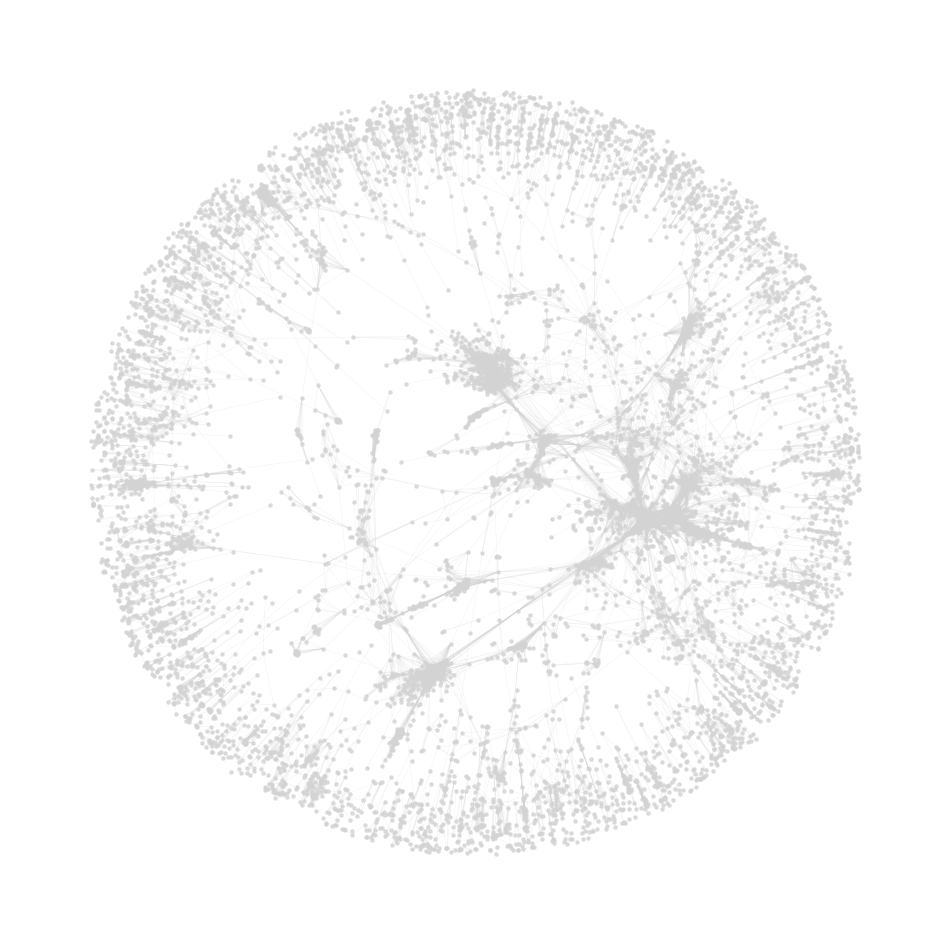

In [78]:
# Draw the graph
plt.figure(figsize=(12, 12))

# Draw the graph
nx.draw_networkx_nodes(
    G, pos,
    node_size=5,
    #node_color=node_color, alpha=0.75)
    node_color='lightgray', alpha=0.75)


# Draw the edges
nx.draw_networkx_edges(
    G, pos, edge_color='lightgray', alpha=0.5, width=0.2)

# Create legend
#import matplotlib.patches as mpatches
#legend_handles = [mpatches.Patch(color=color_map[rank], label=rank) for rank in color_map.keys()]
#plt.legend(handles=legend_handles, title="Hallmark protein", bbox_to_anchor=(1.05, 1), loc='upper left')

# remove the frame
plt.axis('off')

# save the plot as svg
#plt.savefig("foldseekCluster90_0.4_500_ext_hallmark_proteins_final_no_legend.png", dpi=600, bbox_inches='tight')
#plt.savefig("foldseekCluster90_0.4_500_ext_hallmark_proteins_final.svg", format='svg')

plt.show()

## Store data on structure similarity network in CSV

In [ ]:
file_stats = "~/4_structural_clustering/foldseekCluster90_1E-5/foldseekCluster90_1E-5_stats.csv"
df_stats = pd.read_csv(file_stats)

df_stats = df_stats[df_stats["structure_representative_plddt"] > 50]
df_stats_id = df_stats[["structure_representative", "cluster_id", "cluster_size", "structure_representative_plddt"]]
df_stats = df_stats.fillna('None')

In [ ]:
file = "../foldseek_structure_reps_all_vs_all/foldseekCluster90_structure_reps_all_vs_all.tsv"
df = pd.read_csv(file, sep="\t")

# leave only df rows that have cluster_representative from df_stats in query column
df = df[df["query"].isin(df_stats["structure_representative"])]
df = df[df["target"].isin(df_stats["structure_representative"])]

# leave only df rows where evalue is less than 1e-3
df = df[df["evalue"] < 1e-3]

In [ ]:
# Remove rows where query and target are the same
df = df[df["query"] != df["target"]]

In [ ]:
# remove rows from df_stats if cluster_representative not in df['query'] or df['target']
df_stats = df_stats[df_stats["structure_representative"].isin(df["query"]) | df_stats["structure_representative"].isin(df["target"])]

In [ ]:
# merge df with df_stats_id to get cluster_id for each protein
df = pd.merge(df, df_stats_id, left_on="query", right_on="structure_representative")
# drop cluster_representative column
df = df.drop(columns=["structure_representative"])
# rename cluster_id column
df = df.rename(columns={
    "cluster_id": "query_cluster_id",
    "cluster_size": "query_cluster_size",
    "structure_representative_plddt": "query_plddt"})
# merge df with df_stats_id to get cluster_id for each protein
df = pd.merge(df, df_stats_id, left_on="target", right_on="structure_representative")
# drop cluster_representative column
df = df.drop(columns=["structure_representative"])
# rename cluster_id column
df = df.rename(columns={
    "cluster_id": "target_cluster_id",
    "cluster_size": "target_cluster_size",
    "structure_representative_plddt": "target_plddt"})

In [ ]:
df.to_csv("foldseekCluster90_1E-5_network_evalue_below_1E-3_plddt_above_50.csv", index=False)